<img src="images/reddit.jpg" height="50%" width="50%">

<h1><center>An Analysis of the Prevalence of the US Events on Reddit</center></h1>
<center><b>By Nicholus Sakha</b><center>

<hr>
<h1><center>Introduction</center></h1>
<hr>
Reddit is a social media site that is widely used internationally where users can submit content such as text posts, images, and links that can be either upvoted to show that users like the content or downvote to show that users dislike the content. There exists smaller communities called subreddits that allow users to view content and view content for specific topics such as news, politics, video games, and lifestyle. Users can interact with content in a variety of ways, such as directly commenting to posts, gifting rewards to submissions or comments, or simply by upvoting or downvoting comments.

The year 2020 has been a turbulent one for many people worldwide with events such as the Coronavirus pandemic, the U.S. election, riots, and countless other events. As a result, there are more and more submissions with links to news articles that describe these events. With many of these events occuring within the United States, many users and subreddits have grown tired of hearing solely about what is happening in the U.S. and have opted to try to filter posts that were about U.S. events or politics.

In this tutorial, our goal is to verify whether the sentiment that U.S. events have becoming more prevealent over the year 2020. We will then look past the year 2020, and look at the past 11 years to see if there are any trends with how prevalence of the US, specifically if it has grown and if posts about the US are typically more popular than those that are not. 

We will use Pushshift, a Reddit API that allows us to search Reddit comments.

Install the dependencies needed for this project

In [1]:
# In order to get make requests to get the data
import requests
import json

# To work with the data we are going to store it in a dataframe
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

<h1>The Difficulties Getting Data from Reddit</h1> 

Before diving into the data collection, it is important to learn more about the choice to use pushshift for this project, and the challenges that come with querying Reddit for data.

The main difficulty that comes with getting data from Reddit is that users are unable to query Reddit for date-specific results, as we are trying to do in this project. For example, if someone was interested in all submissions from the year 2015, Reddit offers no way to specifically get those submissions. While we would be able to search using the typical Reddit timeframe filters such as last day, last month, last year, and all time, this method of querying becomes increasingly difficult as the timeframe the posts were submitted in becomes further away from present day. For example, if were to attempt to get all the 2015 posts using this method, we would have to use the 'from all time' filter and manually go through each post and determine whether they were in the specified timeframe. This involves working through an *extremely large* number of posts.

It is because of this that we turn to using PushShift to get data.

<h1>About PushShift, its Advantages and Shortcomings</h1>

As described previously, we are unable to use Reddit's exisiting API for this project since we need to get submissions within a specific timeframe. However, PushShift allows us to get around this problem.

PushShift copies submissions into their database at the time they are posted, and updates these submissions in their database with the most up to date version of comments and upvotes in regularly timed intervals. By having what is essentially a deep copy of the Reddit submissions and comments, they have built their API that allows query their database for up to 100 posts at a time, and search for variety of submission parameters, such as timeframe, score, and etc. More specifics can be learned about the PushShift API from the following links at their Reddit, Github, and Site respectively.

* https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/
* https://github.com/pushshift/api
* https://pushshift.io/

However, unfortunately this is not a perfect solution to the problem. Since PushShift has to maintain their own database apart from Reddit, they do not always have the most up to date information regarding submissions from Reddit. This means that data we get back may not always be up to date. Additionally, from analysis, there are some posts that should be among the top submissions in a given year, but are completely missing when a request is sent for the top submissions, a process which will be described in the next sections. From research, it appears that these posts are missing simply because these posts have not been added to the PushShift dataset yet or have not had their upvotes updated yet, which makes sense since there is an ever increasing amount of posts that must be read into the dataset and updated as time goes on. 

While it is unfortunate, since the likelihood of a post being not included in a request for top submissions seems to be tied to the random workings of PushShift's dataset and how it updates, and not properties of the submissions like upvotes, we will label these posts as <b>Missing Completely at Random</b>. This means that when we get the top 1000 posts, we will actually be looking at a subset of the top posts in a given year. While any conclusions we draw will not be as strong as if we had the true data, having a subset of fairly accurate data still will at least be representative of the true trends of Reddit.

<hr>
<h1><center>Data Preparation</center></h1>
<hr>

<h1>Data Collection</h1> 

In order to get the data we need for this project, we need to query Pushshift in order to get the data required. Lets first make some functions. Lets make one that will get the data by querying Pushshift and get the top 100 posts from a subreddit. 

When we send a request to the PushShift API, we get a list of dictionary objects that represent a submission. The size of this list, along with what fields are included in the dictionary, are dependent on the request we send PushShift. To query pushshift, we essentially have to send a GET request to a link, which primarily involves the building of the URL. Before starting, it would be helpful to have these two links read or pulled up:

* https://github.com/pushshift/api#searching-submissions
* https://github.com/pushshift/api#search-parameters-for-submissions

To start, we are going to specify the endpoint, or base URL we will be sending the query to. In the case of submissions this will be: https://api.pushshift.io/reddit/search/submission/

To add additional parameters to search for, we will need to add an additional "?" to the end of the url followed by the parameter name, an equal sign, and finally the value of the parameter. If there are multiple parameters, there will need to be an "&" separating parameters and thier values. An example of this is shown below, with place_holder values being in "<>"

* https://api.pushshift.io/reddit/search/submission/&lt;parameter_1&gt;=&lt;value_1&gt;&amp;&lt;parameter_2&gt;=&lt;value_2&gt;

An example of searching submissions with "Trump" in the title after 2015 would be:

* https://api.pushshift.io/reddit/search/submission/title=Trump&after=2015-12-31

For the data we want, we would need to know the title, the number of upvotes, any flairs (optional text labels), what subreddit the post belongs to, and when it was created. It might also be useful to collect the link to the post and how many comments the post has. We can set this by using the "fields" parameter and setting it equal to a concatenated and comma_separated string in containing the fields below. This will prevent us from getting extranous data back from requests.

* created_utc - when the post was created
* full_link - the link to the actual post on Reddit
* num_comments - the number of comments on the post
* score - the number of upvotes the submission has
* subreddit - the name of the subreddit the submission belongs to
* title - the text title of the submission
* link_flair_text - the text of the flair assigned to the post. Flairs are essentially subcategories submissions can optionally be assigned to.

Unfortunately, it appears that there is not a comprehensive list of fields. To see what ones you want, get a request without the fields parameter and then build a string in a similar way that I do below. More information here: https://github.com/pushshift/api#using-the-fields-parameter

Additionally, we need to include the parameters before and after to get submissions from a specific timeframe. By setting the "sort_type" parameter to score, we are receiving the highest upvoted score. By including the "score=<" we can get all posts below a certain score, which will be used in the next part. Including the "size" parameter will allow us to specify how many submissions we get back, up to 100. Finally, we will need to include the "subreddit" parameter to search specific parameters.

I also included the "title" parameter for general use requesting.

The process of building the string given specific parameters is seen below, as well as an example of some output.

In [2]:
# Lets build the url which we will send requests to in order to get posts within a certain timeframe.

# For the sake of this project, we are interested in the top posts, but you can also change the 'sort_type' to 
# get posts based on the time they were created ('created_utc'), the number of comments the submission has ('num_comments'),
# or mumber of upvotes
def get_pushshift_data(term, start, end, subreddit, num_posts, score_threshold):
    # Limit the data fields we get back. We don't need everything!
    # It'd be useful to collect the flair as a potential y for machine learning predictions we do later
    f = ('created_utc,' +
         'full_link,' +
         'num_comments,' + 
         'score,' + 
         'subreddit,' +
         'title,' +
         'link_flair_text'
         )
    
    # Build the url which will send the data we are looking for
    url = ('https://api.pushshift.io/reddit/search/submission?' + 
           'title=' + str(term) +
           '&after=' + str(start) + 
           '&before=' + str(end) + 
           '&size=' + str(num_posts) + 
           '&fields=' + f +
           '&score=<' + str(score_threshold) + 
           '&sort_type=score' + 
           '&subreddit=' + str(subreddit))
    # We are ensuring we are getting the highest posts with sort
    
    # Get the data, sleep so the successive calls do not trigger a 429 response
    time.sleep(1)
    r = requests.get(url)
    
    # Convert the request into a list of dict objects
    d = json.loads(r.text)
    
    # Return a list of dictionaries for the submissions
    return d['data']

# Lets test it by getting three posts from the world news subreddit in the year 2020 that contains Trump
ex = get_pushshift_data('Trump', '2020-01-01', '2020-12-31', 'worldnews', 3, 1000000)
ex

[{'created_utc': 1578061085,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/ejfywx/trump_accused_of_hypocrisy_for_ordering_the/',
  'link_flair_text': 'Trump',
  'num_comments': 13879,
  'score': 99544,
  'subreddit': 'worldnews',
  'title': 'Trump accused of hypocrisy for ordering the potentially inflammatory killing of a top Iranian general, after a series of tweets emerged from 2011 of him saying former president Obama would start a war with Iran in order to get re-elected'},
 {'created_utc': 1586960839,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/g1sxow/italy_hospital_says_dr_fauci_welcome_with_open/',
  'link_flair_text': 'Trump',
  'num_comments': 5037,
  'score': 99528,
  'subreddit': 'worldnews',
  'title': "Italy hospital says Dr. Fauci 'welcome with open arms' if Trump removes him from his post"},
 {'created_utc': 1586942794,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/g1ooe7/bill_gates_condemns_donald_trump_for_stopping_us/',
  'l

# Data Curation

Now that we pretty general method of querying PushShift RESTful API, lets now get the top 1000 posts in a year and put it in a dataframe

With there being a limit of 100 per query, if we want to get more than 100 submissions per year, we are going to have to have some workaround if we want to have more than 100 submissions per year.

One approach would be to get 100 submissions for each of the 12 months, and then aggregate over them. However, this method would limit the type of exploratory analysis we could do. For example, if we wanted to see the distribution of month vs. upvotes, we would not see the whole picture since the true distribution of the most popular posts may only be in a few select months, rather than all.

What we are going to do instead is sample the whole year but each time keep track of the score. After each query, we will search for all posts below the lowest score from the last batch that was returned. This is why we included the "score=<" field in our function.

At the end of this iterative process, we will have a list of 1000 dictionary objects that can trivially transformed into a Pandas DataFrame. An example of this is output at the bottom of the next code cell, for getting the top 1000 posts of the worldnews Reddit for the year 2020.

In [3]:
# num_top is expected to be a multiple of 100
def get_top_submissions_for_year(subreddit, term, year, num_top):
    return_lst = []
    num_iter = num_top//100
    # Preset the max score to 1 million and lower it based on the lowest submission score
    max_score = 1000000
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    
    for i in range(num_iter):
        return_lst = return_lst + get_pushshift_data(term, start_date, end_date, subreddit, 100, max_score)
        max_score = return_lst[-1]['score']
        
    return pd.DataFrame(return_lst)

# Example of getting the top 1000 entries from worldnews
df = get_top_submissions_for_year('worldnews', '', 2020, 1000)
df

,created_utc,full_link,link_flair_text,num_comments,score,subreddit,title
0,1591877734,https://www.reddit.com/r/worldnews/comments/h0...,Symbolic Move / Arms Exports Controlled by UK ...,4212,142729,worldnews,Scottish Parliament votes for immediate suspen...
1,1578134733,https://www.reddit.com/r/worldnews/comments/ej...,NaN,16927,105205,worldnews,"Bill Gates, the world's second-richest person ..."
2,1595117044,https://www.reddit.com/r/worldnews/comments/ht...,Russia,5735,101881,worldnews,Thousands rally in Russia for 8th straight day...
3,1578061085,https://www.reddit.com/r/worldnews/comments/ej...,Trump,13879,99544,worldnews,Trump accused of hypocrisy for ordering the po...
4,1586960839,https://www.reddit.com/r/worldnews/comments/g1...,Trump,5037,99528,worldnews,Italy hospital says Dr. Fauci 'welcome with op...
...,...,...,...,...,...,...,...
995,1590967915,https://www.reddit.com/r/worldnews/comments/gu...,US internal news,48,507,worldnews,"In Some Cities, Police Officers Joined Protest..."
996,1591696309,https://www.reddit.com/r/worldnews/comments/gz...,NaN,42,504,worldnews,EU hits out at China's bid to rewrite the inte...
997,1578067470,https://www.reddit.com/r/worldnews/comments/ej...,Covered by other articles,51,504,worldnews,A staggering 500 million animals are believed ...
998,1599987269,https://www.reddit.com/r/worldnews/comments/ir...,NaN,127,502,worldnews,Brexit: Tony Blair and John Major unite to con...


<h1>Data Tidying</h1>

Now lets make the DataFrame more tidy, as its current layout is a bit unituitive. 

Lets swap the order of columns around and replace the created_utc column with a datetime object to improve what we can get from looking at the table. Having a datetime object in the column is also much easier for plotting, which we will do in the Exploratory Data Analysis section. 

While the full_link is useful for troubleshooting and confirming, it probably also will not be too useful in our analysis. 

Finally, lets rename the column titles to be a bit more descriptive.

In [4]:
def tidy_df(df):
    df = df.copy()
    date_time_lst = [datetime.utcfromtimestamp(x) for x in df['created_utc']]
    df['date'] = date_time_lst
    df = df.drop(['created_utc', 'full_link'], axis=1)
    if 'link_flair_text' not in df.columns:
        df['link_flair_text'] = np.nan
    df = df[['title','score','date','link_flair_text','num_comments','subreddit']]
    df = df.rename(columns={'title':'submission_name','link_flair_text':'flair'})

    return df

# Example tidying the df we got from the last step
d = tidy_df(df)
d

,submission_name,score,date,flair,num_comments,subreddit
0,Scottish Parliament votes for immediate suspen...,142729,2020-06-11 12:15:34,Symbolic Move / Arms Exports Controlled by UK ...,4212,worldnews
1,"Bill Gates, the world's second-richest person ...",105205,2020-01-04 10:45:33,NaN,16927,worldnews
2,Thousands rally in Russia for 8th straight day...,101881,2020-07-19 00:04:04,Russia,5735,worldnews
3,Trump accused of hypocrisy for ordering the po...,99544,2020-01-03 14:18:05,Trump,13879,worldnews
4,Italy hospital says Dr. Fauci 'welcome with op...,99528,2020-04-15 14:27:19,Trump,5037,worldnews
...,...,...,...,...,...,...
995,"In Some Cities, Police Officers Joined Protest...",507,2020-05-31 23:31:55,US internal news,48,worldnews
996,EU hits out at China's bid to rewrite the inte...,504,2020-06-09 09:51:49,NaN,42,worldnews
997,A staggering 500 million animals are believed ...,504,2020-01-03 16:04:30,Covered by other articles,51,worldnews
998,Brexit: Tony Blair and John Major unite to con...,502,2020-09-13 08:54:29,NaN,127,worldnews


<h1>Getting all the Data</h1>

Now that we have all these functions in place, lets get all the data that we will need.

We will define a function that will combine the functions from all the previous steps and return a single DataFrame ready for work. Essentially, we just need to call tidy_df() on the dataframe we get back from get_top_submissions_for_year(). The parameters needed for this are the subreddit we are interested in searching (subreddit), the term in the title (term), if any, the year we are interested in (year) , and finally the number of top posts we want (num_top), which must be a multiple of 100.

Since we have to include a wait so that we do not get a 429 Response (Too Many Requests), it would be much easier, especially in the future to write all this data to a csv so we can read it later. Pandas has a method for doing this given a DataFrame, making this step extremely easy. 

The only other thing we are going to do, is just repeat the above function for 11 different years, and store the resulting DataFrame in a .csv in our working directory. Lets call this function get_data_10_years(), taking the string name of a subreddit as a parameter.

Finally, lets only call this function if necessary, as the waiting to avoid a 429 error is extensive!

In [5]:
def get_data(subreddit, term, year, num_top):
    return tidy_df(get_top_submissions_for_year(subreddit, term, year, num_top))

# Function to get all world news data
def get_data_10_years(subreddit):
    year_lst = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
    return_lst = []
    for year in year_lst:
        df = get_data(subreddit, '', year, 1000)
        return_lst.append(df)
        df.to_csv(subreddit + '_' + str(year) + '.csv', index = False, header = True)
    return return_lst
       
# Keep a boolean value to determine if we need to re-collect data
fresh_run = False

if (fresh_run):
    worldnews_lst = get_data_10_years('worldnews')

<hr>
<h1><center>Exploratory Data Analysis</center></h1>
<hr>

Now that we have the data, we can do some exploratory data analysis. For the of reproducability, I have stored the dataframes that I will using in my analysis in this zip so that they can be downloaded if anything were to happen to either the Reddit API or the PushShift API. 

<a href="data.zip">Click here to download the data in a .zip file.</a>

Unfortunately, we will have to reconvert the date column into a datetime object when we read it from a csv. Luckily, Pandas has a function that will do this for us without much work because of the format the datetime object was saved as in the csv.

To start, lets load the .csv files we created in the last part into variables we will perform analysis on.

In [11]:
def convert_str_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

# My csv files are in a directory called data
worldnews_2020 = convert_str_datetime(pd.read_csv('data/worldnews_2020.csv'))
worldnews_2019 = convert_str_datetime(pd.read_csv('data/worldnews_2019.csv'))
worldnews_2018 = convert_str_datetime(pd.read_csv('data/worldnews_2018.csv'))
worldnews_2017 = convert_str_datetime(pd.read_csv('data/worldnews_2017.csv'))
worldnews_2016 = convert_str_datetime(pd.read_csv('data/worldnews_2016.csv'))
worldnews_2015 = convert_str_datetime(pd.read_csv('data/worldnews_2015.csv'))
worldnews_2014 = convert_str_datetime(pd.read_csv('data/worldnews_2014.csv'))
worldnews_2013 = convert_str_datetime(pd.read_csv('data/worldnews_2013.csv'))
worldnews_2012 = convert_str_datetime(pd.read_csv('data/worldnews_2012.csv'))
worldnews_2011 = convert_str_datetime(pd.read_csv('data/worldnews_2011.csv'))
worldnews_2010 = convert_str_datetime(pd.read_csv('data/worldnews_2010.csv'))

To begin, lets look at the distribution of upvotes vs. time for the year 2020. There were two notable events in the US that garnered a lot of international attention, those being:

1) Initial COVID outbreaks in the US in March/April

2) BLM Protests that occurred after the death of George Floyd in the Summer of 2020

By visualizing this distribution, we will be able to see if there is more popularity during these months and likely for submissions about these topics, or if it is more uniform, we will less evidence to reject the null hypothesis that the US events are not more popular than other events.

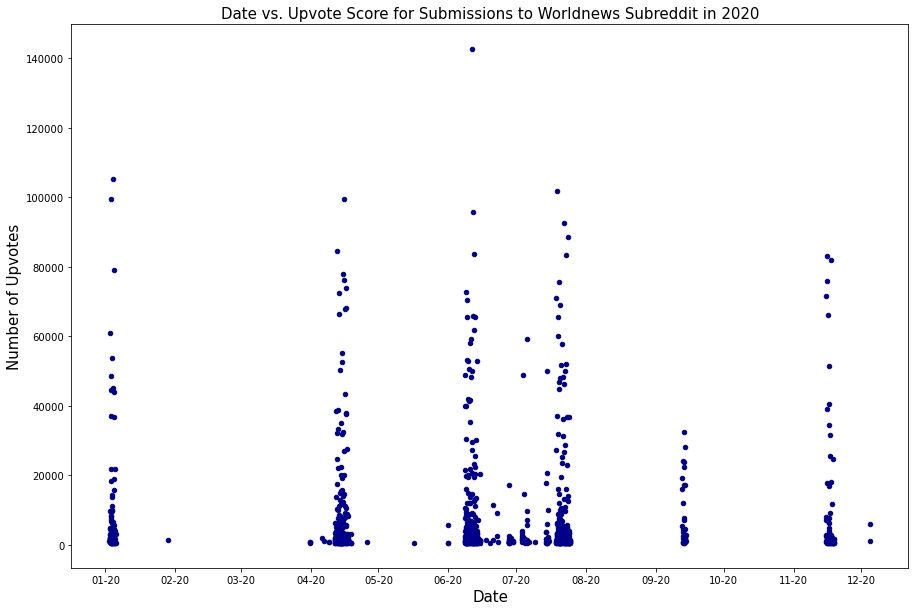

In [7]:
plot = worldnews_2020.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Looking at the scatter plot above, it would appear that our predicition may at least be partially true. Lets investigate this further by looking making simple classifiers for the title to see whether they fit in our category.

To do this, lets just make a list of terms that may be in the title of a post about that topic. If any term is within that title, we would keep it and display its score on the scatterplot.

For the first event on the Coronavirus, some terms that might be a good indicator that the submission is about would just be if it contained the different variations that the modern Coronavirus has been referred to, such as:
* covid
* covid-19
* corona
* coronavirus

We can use the (?i) marker when defining our term list since there may be many cases of different captialization. Since the words do not mean drastically different things depending on capitalization, we should ignore. However, we should not do the same thing in the case of "us" and "US"

Additionally, we can use flairs to determine the content. The worldnews subreddit has used the "COVID-19" flair to denote submissions as related to COVID, and we can use this to also determine whether a submission is about the coronavirus.

Submissions that match:
253


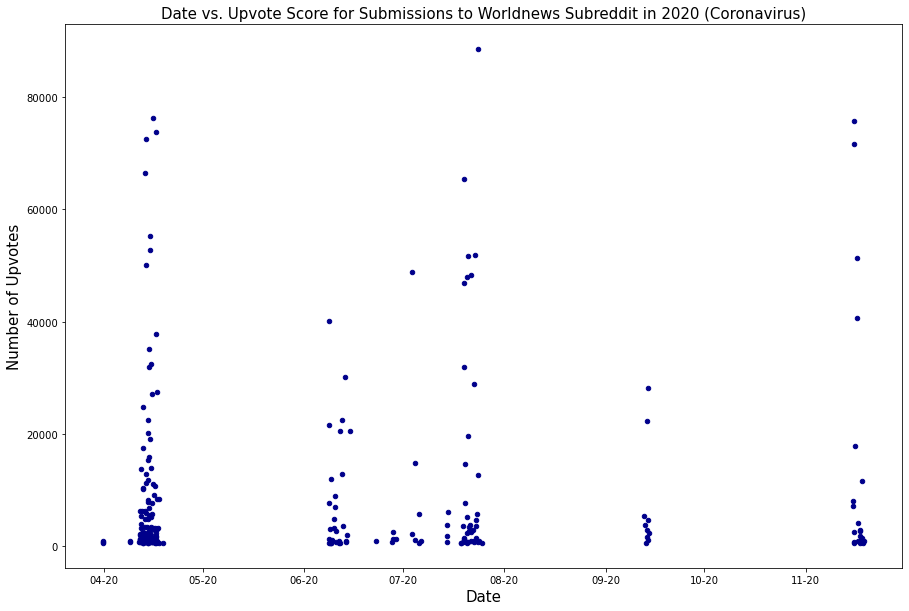

In [84]:
terms = '(?i)covid|covid-19|corona|coronavirus'
#  or worldnews_2020['flair'] == 'COVID-19'
lst_1 = worldnews_2020['submission_name'].str.contains(terms).tolist()
lst_2 = (worldnews_2020['flair'] == 'COVID-19').tolist()
filter_lst = []
for i in range(len(lst_1)):
    filter_lst.append(lst_1[i] or lst_2[i])
filter_lst = pd.Series(filter_lst)
covid_df = worldnews_2020[filter_lst]
print('Submissions that match:')
print(len(covid_df))
plot = covid_df.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020 (Coronavirus)', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

With the scatter plot above, it seems that out prediction of a surge of posts about the Coronavirus when it hit the US in Spring may be true! To look further, lets make another 'classifier' to filter out posts further to see what proportion of these posts about Coronavirus may also be related to the US.

For the terms that may indicate whether or not whether a post is about the US, lets use (case specific):
* US
* United States
* U.S.

Submissions that match:
27


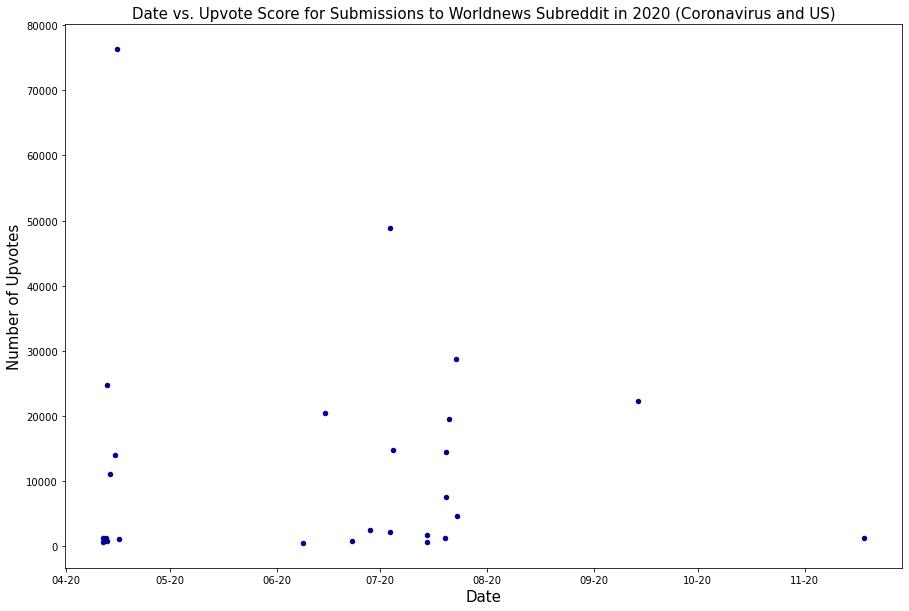

In [73]:
us_terms = 'US|United States|U.S.'
filter_lst = covid_df['submission_name'].str.contains(us_terms).tolist()
covid_us_df = covid_df[filter_lst]
print('Submissions that match:')
print(len(covid_us_df))
plot = covid_us_df.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020 (Coronavirus and US)', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

By filtering the submissions further, we see that top submissions about the Coronavirus and the US are either centered around April, or spread out in the summer. It's worth noting that of the original 253 coronavirus submissions in the year, 27 seem to about about the US.

Lets take one further look at how many fall within April and how many do not, in addition to looking at the top few posts.

In [79]:
temp = covid_us_df.copy()
with pd.option_context('display.max_colwidth', None):
  display(temp.drop(['flair','num_comments','subreddit'], axis=1).head(5))

# Now lets see how many of these 27 posts were in April
count = 0
may_datetime = datetime.strptime('2020-05-01', '%Y-%m-%d')
for d in temp['date'].to_list():
    if d < may_datetime:
        count = count + 1
        
print('Total submissions in April: ' + str(count))

,submission_name,score,date
15,"We Alerted The World' To Coronavirus On Jan. 5, WHO Says In Response To U.S.",76343,2020-04-15 20:18:40
55,"Mexico closes US border in Arizona to stop July 4th visitors, citing COVID-19 fears",48789,2020-07-03 20:58:04
98,Bill Gates denies conspiracy theories that say he wants to use coronavirus vaccines to implant tracking devices - 28% of U.S. adults believed a debunked conspiracy theory suggesting Gates planned to use a vaccine to implant microchips in billions of people to monitor their movements,28827,2020-07-22 20:22:13
109,"Caribbean nations can’t get U.S. masks, ventilators for COVID-19 under Trump policy",24721,2020-04-12 17:35:35
117,A 26 year old US woman has acted as super spreader for one of Germany's currently largest outbreak of Covid-19 when she visited multiple clubs and bars in one evening despite showing coronavirus-like symptoms.,22326,2020-09-13 14:11:02


Total submissions in April: 10


Looking at this, there are about 10 submissions clustered together in April.

Currently, these statistics are not too telling of a US prevalence on the worldnews subreddit. Only about 10% of all top submissions about the Coronavirus are about the US. Lets keep looking with the Black Lives Matter Protests in the summer of 2020.

Lets repeat the process that we did when searching for submissions about the Coronavirus and create a list of terms to search for submissions relevant to the Black Lives Matter protests. Some terms that might be a good hit are (non-case sensitive):

* blm
* riot
* protest
* floyd
* black lives matter
* defund
* rioters

Theses terms were chosen because the were some of the most popular words used to describe the protests that went on at the time. I also included 'defund' because of the popular saying of "defund the police" that was going on during this time.

54


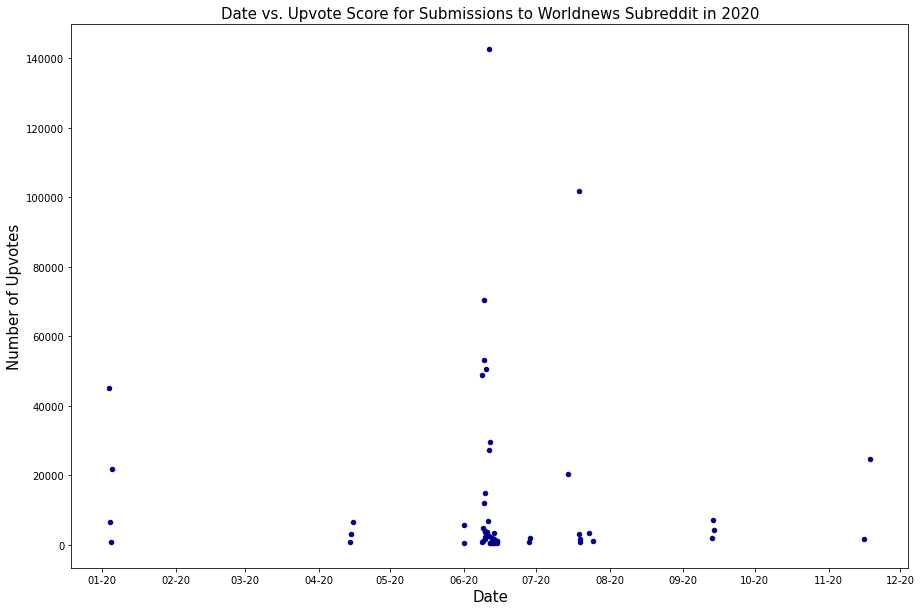

In [85]:
terms = '(?i)blm|riot|protest|floyd|black lives matter|defund|rioters'
#  or worldnews_2020['flair'] == 'COVID-19'
temp = worldnews_2020[worldnews_2020['submission_name'].str.contains(terms)]
print(len(temp))
plot = temp.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

How to deal with not all posts being present in dataset problem?

Plans:

1) Investigate whether the above frequency centers can be attributed to the posts we talked about
-> using simple classifiers, i.e. title contains riots, blm etc etc

2) Calculate Frequency of words using a BoW and IDF representation to see which terms are the most popular, per year

3) Use simple classier to mark submissions as either US or not (whether they contain US or Trump, e.g.) and then find a regression line for the data.

4) Train ML model to predict average score on posts given that they are about the US and year, with interaction terms